In [18]:
%matplotlib inline
import pandas as pd
import numpy as np
import psycopg2
import matplotlib.pyplot as pp
import matplotlib.dates as dates
import pylab as pl
import folium
from IPython.display import HTML
import seaborn as sns
from scipy import stats
from folium.plugins import MarkerCluster
import datetime as dt

In [3]:
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

In [49]:
#Importing Data and Resolving Datatypes
result = pd.read_csv('/Users/ryan/Desktop/baseline/notebook/baseline_data_for_viewer.csv', header=0, dtype= 'unicode', parse_dates=['date'])   
#starting with the start date of the survey
result = result.loc[result['date'] > '2018-05-10']

In [72]:
#generating Productivity Tables
result['complete'] = pd.to_numeric(result['complete'], errors='coerce')
result['hh_size_hhinfo'] = pd.to_numeric(result['hh_size_hhinfo'], errors='coerce')
result['incomplete'] = pd.to_numeric(result['incomplete'], errors='coerce')
result['perm_unavail'] = pd.to_numeric(result['perm_unavail'], errors='coerce')
result['refusal'] = pd.to_numeric(result['refusal'], errors='coerce')
#grouping by date
prod_table = result[['state_name','complete', 'date']].groupby(['date']).sum()
#generating some averages
prod_table['Total Attempted'] = result[['scto_uuid', 'date']].groupby(['date']).count()
prod_table['Surveyors Working'] = result[['dod_enumerator_id_intro', 'date']].groupby(['date'])['dod_enumerator_id_intro'].nunique()
prod_table['Avg Daily Attempts by Surveyor'] = ((prod_table['Total Attempted'] / prod_table['Surveyors Working']))
prod_table['Avg Daily Completes by Surveyor'] = ((prod_table['complete'] / prod_table['Surveyors Working']))
#rendering the table
(prod_table.loc[:]
    .style
    .set_caption("Productivity by Date")
    .background_gradient(cmap='RdBu', low=0, high=0.2,subset=['complete', 'Total Attempted', 'Surveyors Working','Avg Daily Attempts by Surveyor','Avg Daily Completes by Surveyor']))


,complete,Total Attempted,Surveyors Working,Avg Daily Attempts by Surveyor,Avg Daily Completes by Surveyor
date,,,,,
2018-05-11 00:00:00,234,621,257,2.41634,0.910506
2018-05-12 00:00:00,337,774,294,2.63265,1.14626
2018-05-13 00:00:00,8,14,7,2,1.14286
2018-05-14 00:00:00,366,883,298,2.96309,1.22819
2018-05-15 00:00:00,381,826,287,2.87805,1.32753
2018-05-16 00:00:00,361,976,308,3.16883,1.17208
2018-05-17 00:00:00,378,950,311,3.05466,1.21543
2018-05-18 00:00:00,383,993,312,3.18269,1.22756
2018-05-19 00:00:00,236,587,250,2.348,0.944


In [83]:
#generating Productivity Tables by State, Dist
#grouping by date
result = result.loc[result['date'] > '2018-05-10']
prod = result[['state_name','dist_name','complete', 'date']].groupby(['state_name', 'dist_name', 'date']).sum()

#generating some averages
prod['Total Attempted'] = result[['scto_uuid', 'state_name', 'dist_name', 'date']].groupby(['state_name', 'dist_name', 'date']).count()
prod['Avg Daily Surveyors Working'] = result[['dod_enumerator_id_intro', 'state_name', 'dist_name', 'date']].groupby(['state_name', 'dist_name', 'date'])['dod_enumerator_id_intro'].nunique()
prod['Avg Daily Attempts by Surveyor'] = ((prod['Total Attempted'] / prod['Avg Daily Surveyors Working']))
prod['Avg Daily Completes by Surveyor'] = ((prod['complete'] / prod['Avg Daily Surveyors Working']))
prod.drop(['complete', 'Total Attempted'], 1, inplace = True)
prod = prod.groupby(['state_name', 'dist_name']).mean()
#rendering the table
(prod.loc[:]
    .style
    .set_caption("Productivity by District")
    .background_gradient(cmap='RdBu', low=0, high=0.2,subset=['Avg Daily Surveyors Working','Avg Daily Attempts by Surveyor','Avg Daily Completes by Surveyor']))


In [85]:
#labeling as complete only those surveys that actually resulted in a survey (not refusals or perm_unavail)
result.loc[result['incomplete'] == 0, 'complete'] = 1
result.loc[result['refusal'] == 1, 'complete'] = 0
result.loc[result['perm_unavail'] == 1, 'complete'] = 0
#producing a totals table, grouped by state
total = result[['state_name','refusal','perm_unavail','incomplete','complete']].groupby(['state_name']).sum()
total['Total Attempted'] = result[['state_name','scto_uuid']].groupby(['state_name']).count()
#adding a summary row
#total.loc['All'] = total.sum()
#rendering the table
(total[:]
    .style
    .set_caption("Productivity by State")
    .background_gradient(cmap='RdBu', low=0, high=0.2,subset=['complete','Total Attempted'])
    .background_gradient(cmap='coolwarm', low=0.5, high=0.1,subset=['refusal', 'perm_unavail', 'incomplete']))

,refusal,perm_unavail,incomplete,complete,Total Attempted
state_name,,,,,
ASSAM,1,33,444,707,1185
BIHAR,19,64,890,411,1383
JHARKHAND,2,15,278,183,477
MADHYA PRADESH,12,92,692,511,1307
MAHARASHTRA,2,5,136,95,238
RAJASTHAN,7,29,200,196,432
UTTAR PRADESH,28,58,977,606,1669


In [84]:
#producing a counts table by district
counts = result[['state_name','dist_name','refusal','incomplete','complete', 'perm_unavail']].groupby(['state_name','dist_name']).sum()
#adding total attemped
counts['Total Attempted'] = result[['state_name','dist_name','dod_enumerator_id_intro']].groupby(['state_name','dist_name']).count()
#converting to percentages
counts['% Refusal'] = ((counts['refusal'] / counts['Total Attempted']))
counts['% Incomplete'] = ((counts['incomplete'] / counts['Total Attempted']))
counts['% Unavailable'] = ((counts['perm_unavail'] / counts['Total Attempted']))
#dropping the number columns
counts = counts.drop(columns=['refusal', 'incomplete','perm_unavail'])
counts = counts[['% Refusal','% Unavailable', '% Incomplete','complete','Total Attempted']]
#formatting and rendering the table
(counts.loc[:]
    .style
    .set_caption("Form Status by District")
    .format({'% Refusal': "{:.1%}", '% Unavailable': "{:.1%}",'% Incomplete': "{:.1%}"})
    .background_gradient(cmap='RdBu', low=0, high=0.2,subset=['complete', 'Total Attempted'])
    .background_gradient(cmap='coolwarm', low=0.5, high=0.1,subset=['% Refusal', '% Incomplete', '% Unavailable']))

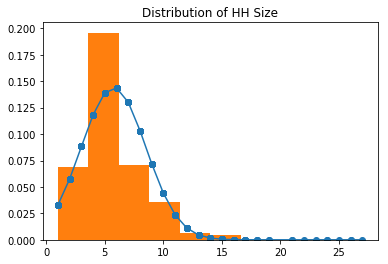

In [56]:
#hh_size
h = sorted(result['hh_size_hhinfo'].dropna())  #sorted

fit = stats.norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed

pl.plot(h,fit,'-o')
pl.hist(h,normed=True)
pl.title("Distribution of HH Size")
pl.show()  

In [68]:
#generating the map
#a = result.gps_location_end.str.split(' ').dropna()
#b = pd.DataFrame((item for item in a), columns = ['lat','long','alt','acc'])
#b['lat'] = pd.to_numeric(b['lat'], errors='coerce')
#b['long'] = pd.to_numeric(b['long'], errors='coerce')

In [69]:
'''
lat = b['lat'].values
lon = b['long'].values

url_base = 'http://server.arcgisonline.com/ArcGIS/rest/services/'
service = 'World_Street_Map/MapServer/tile/{z}/{y}/{x}'
tileset = url_base + service


map_osm = folium.Map(location=[b['lat'].mean(), 
   b['long'].mean()],zoom_start=5, control_scale = True, tiles=tileset, attr='USGS style')

mc = folium.plugins.MarkerCluster()

for row in b.itertuples():
    mc.add_child(folium.Marker(location=[row.lat,  row.long]))

map_osm.add_child(mc)

map_osm.get_root().add_child(folium.Element("<h1>Submitted Forms Mapped by GPS</h1>"))
map_osm
'''

'\nlat = b[\'lat\'].values\nlon = b[\'long\'].values\n\nurl_base = \'http://server.arcgisonline.com/ArcGIS/rest/services/\'\nservice = \'World_Street_Map/MapServer/tile/{z}/{y}/{x}\'\ntileset = url_base + service\n\n\nmap_osm = folium.Map(location=[b[\'lat\'].mean(), \n   b[\'long\'].mean()],zoom_start=5, control_scale = True, tiles=tileset, attr=\'USGS style\')\n\nmc = folium.plugins.MarkerCluster()\n\nfor row in b.itertuples():\n    mc.add_child(folium.Marker(location=[row.lat,  row.long]))\n\nmap_osm.add_child(mc)\n\nmap_osm.get_root().add_child(folium.Element("<h1>Submitted Forms Mapped by GPS</h1>"))\nmap_osm\n'